# Práctica 3


## Importar Librerias


In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable, List, Tuple
from tqdm import tqdm

## Dataset


### Lectura del Dataset


In [137]:
df = pd.read_csv("diabetes_dataset.csv")
df_2019 = df[df["year"] == 2019]
df_2019.drop(columns=["year"], inplace=True)
df_2019.head()

C:\Users\jlflo\AppData\Local\Temp\ipykernel_17976\1727960749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2019.drop(columns=["year"], inplace=True)


,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
73,Male,55.00,Alabama,0,0,0,1,0,0,0,No Info,27.94,6.0,158,0
335,Female,1.72,Alabama,0,0,0,1,0,0,0,No Info,16.28,6.2,100,0
337,Female,55.00,Alabama,0,1,0,0,0,0,0,never,28.30,6.0,140,0
340,Female,53.00,Alabama,0,1,0,0,0,0,0,never,35.84,6.0,155,0
341,Female,38.00,Alabama,0,1,0,0,0,0,0,never,31.91,5.8,200,0


### Discretización


In [138]:
cols_discretizar = {
    "age": {
        "niños": [0, 9],
        "adolescentes": [10, 19],
        "jóvenes": [20, 59],
        "adulto mayor": [60],
    },
    "bmi": {
        "bajo peso": [18.49],
        "peso normal": [18.5, 24.99],
        "sobrepeso": [25, 29.99],
        "obesidad": [30],
    },
    "hbA1c_level": {"normal": [5.6], "limite": [5.7, 6.4], "sobre": [6.5]},
    "blood_glucose_level": {
        "hipoglucemia": [79],
        "normal": [80, 159],
        "elevado": [160, 199],
        "critico": [200],
    },
}

race = {
    "race:AfricanAmerican": 0,
    "race:Asian": 1,
    "race:Caucasian": 2,
    "race:Hispanic": 3,
    "race:Other": 4,
}


def discretizar_col(col, bins: dict):
    factor = 0
    for label, edges in bins.items():
        if len(edges) == 1:
            if factor == 0:
                if col <= edges[0]:
                    return label

            else:
                if col >= edges[0]:
                    return label
        else:
            if edges[0] <= col <= edges[1]:
                return label
        factor += 1


def discretizar_raza(col, valor: int):
    if col == 1:
        return valor


def discretizar_df(df: pd.DataFrame, cols_dict: dict, race: dict) -> pd.DataFrame:
    df_copy = df.copy()
    for col, bins in cols_dict.items():
        df_copy[col] = df_copy[col].apply(lambda x: discretizar_col(x, bins))

    condiciones = [df_copy[col] == 1 for col in race.keys()]
    valores = list(race.values())
    df_copy["race"] = np.select(condiciones, valores, default=-1)
    df_copy.drop(columns=list(race.keys()), inplace=True)
    return df_copy


df_discretizado = discretizar_df(df_2019, cols_discretizar, race)
df_discretizado.head()

,gender,age,location,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,race
73,Male,jóvenes,Alabama,0,0,No Info,sobrepeso,limite,normal,0,3
335,Female,niños,Alabama,0,0,No Info,bajo peso,limite,normal,0,3
337,Female,jóvenes,Alabama,0,0,never,sobrepeso,limite,normal,0,1
340,Female,jóvenes,Alabama,0,0,never,obesidad,limite,normal,0,1
341,Female,jóvenes,Alabama,0,0,never,obesidad,limite,critico,0,1


In [139]:
vals_numericos = {
    "age": {
        "niños": 0,
        "adolescentes": 1,
        "jóvenes": 2,
        "adulto mayor": 3,
    },
    "bmi": {
        "bajo peso": 0,
        "peso normal": 1,
        "sobrepeso": 2,
        "obesidad": 3,
    },
    "hbA1c_level": {"normal": 0, "limite": 1, "sobre": 2},
    "blood_glucose_level": {
        "hipoglucemia": 0,
        "normal": 1,
        "elevado": 2,
        "critico": 3,
    },
    "gender": {"Male": 0, "Female": 1},
}


def dummy_col(col, vals: dict):
    for label, val in vals.items():
        if col == label:
            return int(val)


def dummy_df(df: pd.DataFrame, cols_discretizar: dict) -> pd.DataFrame:
    for col, bins in cols_discretizar.items():
        df[col] = df[col].apply(lambda x: dummy_col(x, bins))
    for col in df.columns:
        # Verificar si la columna necesita conversión
        necesita_conversion = False

        if df[col].dtype == "object":
            # Es texto, necesita conversión
            necesita_conversion = True
        elif df[col].dtype in ["float64", "float32", "int64", "int32"]:
            # Es numérica, verificar si tiene valores no enteros
            try:
                valores_no_nulos = df[col].dropna()
                if len(valores_no_nulos) > 0:
                    # Verificar si todos los valores son enteros
                    necesita_conversion = not all(
                        valores_no_nulos == valores_no_nulos.astype(int)
                    )
            except:
                necesita_conversion = True

        if necesita_conversion:
            # Obtener valores únicos (excluyendo NaN)
            valores_unicos = df[col].dropna().unique()

            # Crear el mapeo (ordenado alfabéticamente)
            mapeo = {
                valor: idx for idx, valor in enumerate(sorted(valores_unicos, key=str))
            }

            # Guardar en el diccionario
            cols_discretizar[col] = mapeo

            # Aplicar la conversión
            df[col] = df[col].map(mapeo)

    return df, cols_discretizar


df_dummy, vals_numericos = dummy_df(df_discretizado, vals_numericos)
df_dummy.head()

,gender,age,location,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,race
73,0.0,2,0,0,0,0,2,1,1,0,3
335,1.0,0,0,0,0,0,0,1,1,0,3
337,1.0,2,0,0,0,4,2,1,1,0,1
340,1.0,2,0,0,0,4,3,1,1,0,1
341,1.0,2,0,0,0,4,3,1,3,0,1


## Funciones de MOEA/D


### Generar Población


In [140]:
def generar_poblacion(df_original: pd.DataFrame, N: int = 120) -> np.ndarray:
    """
    Genera una población aleatoria a partir de una base de datos original.
    args:
        df_original (pd.DataFrame): DataFrame original del cual se generará la población.
        N (int): Tamaño de la población a generar. Default es 120.
    returns:
        np.ndarray: Arreglo con la población generada.
    """
    n_df = pd.DataFrame(columns=df_original.columns)
    for col in df_original.columns:
        n_df[col] = np.random.choice(df_original[col], size=N, replace=True)
    poblacion = np.zeros((N, 2, len(n_df.columns)))
    for i in range(len(poblacion)):
        poblacion[i][0] = np.random.choice([0, 1, 2], size=n_df.shape[1])
        poblacion[i][1] = n_df.iloc[i].values

    return poblacion

### Dan Dennis


In [141]:
from math import comb


def calcular_H(N, M):
    """
    Calcula H dado N (puntos deseados) y M (objetivos)
    mediante búsqueda iterativa.
    """
    H = 1
    while comb(H + M - 1, M - 1) < N:
        H += 1

    puntos_generados = comb(H + M - 1, M - 1)

    if puntos_generados == N:
        return H
    else:
        print(
            f"No existe H exacto. H={H} genera {puntos_generados} puntos (cercano a {N})"
        )
        return H


def Dan_Dennis(poblacion: np.ndarray, M=4) -> np.ndarray:
    """
    Ejecuta el método de generación de población de Dan Dennis.
    args:
        poblacion (np.ndarray): Matriz original del cual se generará la población.
        M (int): Número de objetivos.
    returns:
        np.ndarray: Arreglo con los pesos.
    """
    N = poblacion.shape[0]
    H = calcular_H(N, M)
    # print(f"Usando H={H} para generar la población.")

    def generar_particiones(M, H, profundidad=0, suma_actual=0, particion_actual=[]):
        """
        Genera recursivamente todas las particiones que suman H.
        """
        if profundidad == M - 1:
            # Última posición: asignar lo que falta
            particion_actual.append(H - suma_actual)
            particiones.append(particion_actual[:])
            particion_actual.pop()
            return

        # Probar todos los valores posibles para la posición actual
        for valor in range(H - suma_actual + 1):
            particion_actual.append(valor)
            generar_particiones(
                M, H, profundidad + 1, suma_actual + valor, particion_actual
            )
            particion_actual.pop()

    particiones = []
    generar_particiones(M, H)

    # Convertir particiones a pesos
    weights = np.array(particiones, dtype=float) / H

    return weights

### Vencidario


In [142]:
def encontrar_vecindarios(pesos: np.ndarray, T: int) -> List[np.ndarray]:
    """
    Encuentra los T vecinos más cercanos para cada vector de peso.

    args:
        pesos: Matriz de vectores de peso (n, m)
        T: Tamaño del vecindario
    returns:
        List[np.ndarray]: Lista de vecindarios (índices)
    """
    n = pesos.shape[0]
    vecindarios = []

    for i in range(n):
        distancias = np.linalg.norm(pesos - pesos[i], axis=1)
        vecinos = np.argsort(distancias)[:T]
        vecindarios.append(vecinos)

    return vecindarios

### Evaluar Individuos


In [143]:
def comparar_individuos(
    fy: np.ndarray,
    fx_j: np.ndarray,
    lambda_j: np.ndarray,
    z: np.ndarray,
    evaluar_con_agregacion: Callable,
) -> bool:
    """
    Compara si el hijo y es mejor que x_j según la función de agregación.

    returns:
        True si y es mejor
    """

    g_y = evaluar_con_agregacion(fy, lambda_j, z)
    g_xj = evaluar_con_agregacion(fx_j, lambda_j, z)

    return g_y < g_xj

### Punto Ideal


In [144]:
def actualizar_punto_ideal(
    z: np.ndarray,
    individuo: np.ndarray,
    objetivos: np.ndarray,
) -> np.ndarray:
    """
    Actualiza el punto ideal con los mejores valores de cada objetivo.
    args:
        z (np.ndarray): Punto ideal actual de shape (m,) donde m es número de objetivos
        individuo (np.ndarray): Individuo a evaluar
        objetivos (np.ndarray): Objetivos de un individuo
        df (pd.DataFrame): DF del dataset a evaluar
    returns:
        np.ndarray: Punto ideal actualizado
    """
    z_nuevo = z.copy()
    for i, objetivo in enumerate(objetivos):
        z_nuevo[i] = min(z_nuevo[i], objetivo)

    return z_nuevo


def inicializar_punto_ideal(
    poblacion: np.ndarray, objetivos: np.ndarray, problema: int
) -> np.ndarray:
    """
    Inicializa el punto ideal evaluando la población inicial.
    """
    if problema == 1:
        M = 3
    else:
        M = 4
    z = np.full(M, 0.0)

    for i in range(len(poblacion)):
        z = actualizar_punto_ideal(z, poblacion[i], objetivos[i])

    return z

### Funciones de Agregación


In [145]:
def tchebycheff(f_x: np.ndarray, lambda_j: np.ndarray, z: np.ndarray) -> float:
    """
    Función de agregación de Tchebycheff.
    args:
        f_x: Vector de valores objetivos del individuo
        lambda_j: Vector de pesos
        z: Punto ideal
    returns:
        float: Valor de la función de agregación (menor es mejor)
    """
    return np.max(lambda_j * np.abs(f_x - z))

In [146]:
def weighted_sum(f_x: np.ndarray, lambda_j: np.ndarray, z: np.ndarray) -> float:
    """
    Función de agregación de suma ponderada.

    args:
        f_x: Vector de valores objetivos del individuo
        lambda_j: Vector de pesos
        z: Punto ideal
    returns:
        float: Valor de la función de agregación
    """
    return np.sum(lambda_j * (f_x - z))

In [147]:
def pbi(
    f_x: np.ndarray,
    lambda_j: np.ndarray,
    z: np.ndarray,
    theta: float = 5.0,
) -> float:
    """
    Función de agregación PBI (Penalty-Based Boundary Intersection).

    args:
        f_x: Vector de valores objetivos del individuo
        lambda_j: Vector de pesos
        z: Punto ideal
        theta: Parámetro de penalización
    returns:
        float: Valor de la función de agregación
    """
    diferencia = f_x - z
    norma_lambda = np.linalg.norm(lambda_j)

    if norma_lambda == 0:
        return np.inf

    d1 = np.abs(np.dot(diferencia, lambda_j)) / norma_lambda

    punto_proyeccion = z + d1 * lambda_j
    d2 = np.linalg.norm(f_x - punto_proyeccion)

    return d1 + theta * d2

## Funciones Objetivo


### Funciones principales


In [148]:
def obtener_x_y(individuo: np.ndarray):
    """
    Versión vectorizada para obtener índices X e Y.
    """
    index = individuo[0]
    x = np.where(index == 1)[0]
    y = np.where(index == 2)[0]
    return x, y


def obtener_matriz_confusion(individuo: np.ndarray, df: pd.DataFrame):
    """
    Calcula la matriz de confusión para un individuo diploide (OPTIMIZADA).
    Usa operaciones vectorizadas de NumPy para mayor velocidad.
    """
    x, y = obtener_x_y(individuo)

    cromosoma = individuo[1]

    df_values = df.values

    if len(x) > 0:
        mask_x = np.all(df_values[:, x] == cromosoma[x], axis=1)
    else:
        mask_x = np.ones(len(df), dtype=bool)
    if len(y) > 0:
        mask_y = np.all(df_values[:, y] == cromosoma[y], axis=1)
    else:
        mask_y = np.ones(len(df), dtype=bool)

    a = np.sum(mask_x & mask_y)
    b = np.sum(~mask_x & mask_y)
    c = np.sum(mask_x & ~mask_y)
    d = np.sum(~mask_x & ~mask_y)

    return [[a, b], [c, d]]

In [149]:
def support(a: int, N: int) -> float:
    """
    Calcula el soporte de un individuo.
    args:
        a (int): X ∩ Y.
        N (int): Número total de instancias.
    returns:
        float: Soporte del individuo.
    """

    return a / N


def confidence(a: int, c: int) -> float:
    """
    Calcula la confianza de un individuo.
    args:
        a (int): X ∩ Y.
        c (int): X ∩ ~Y.
    returns:
        float: Confianza del individuo.
    """

    if a + c == 0:
        return 0.0
    return a / (a + c)


def lift(a: int, b: int, c: int, N: int) -> float:
    """
    Calcula el lift de un individuo.
    args:
        a (int): X ∩ Y.
        b (int): ~X ∩ Y.
        c (int): X ∩ ~Y.
        N (int): Número total de instancias.
    returns:
        float: Lift del individuo.
    """

    if (a + b) * (a + c) == 0:
        return 0.0
    return (a * N) / ((a + b) * (a + c))


def conviction(a: int, b: int, c: int, d: int, N: int) -> float:
    """
    Calcula la convicción de un individuo.
    args:
        a (int): X ∩ Y.
        b (int): ~X ∩ Y.
        c (int): X ∩ ~Y.
        d (int): ~X ∩ ~Y.
        N (int): Número total de instancias.
    returns:
        float: Convicción del individuo.
    """

    den = 1 - a / (a + c)
    if den == 0:
        return 0.0
    return (1 - (a + b) / N) / den

### Problema de Optimización 1


In [150]:
def casual_support(a: int, d: int, N: int) -> float:
    """
    Calcula el soporte causal.
    args:
        a (int): X ∩ Y.
        d (int): ~X ∩ ~Y.
        N (int): Número total de instancias.
    returns:
        float: Soporte causal del individuo.
    """

    return (a + d) / N


def casual_confidence(a: int, b: int, c: int, d: int) -> float:
    """
    Calcula la confianza causal.
    args:
        a (int): X ∩ Y.
        b (int): ~X ∩ Y.
        c (int): X ∩ ~Y.
        d (int): ~X ∩ ~Y.
    returns:
        float: Confianza causal del individuo.
    """

    if a + c == 0 or b + d == 0:
        return 0.0
    conf_xy = a / (a + c)

    conf_notx_noty = d / (b + d)

    return 0.5 * (conf_xy + conf_notx_noty)


def max_confidence(a: int, b: int, c: int) -> float:
    """
    Calcula la confianza máxima.
    args:
        a (int): X ∩ Y.
        b (int): ~X ∩ Y.
        c (int): X ∩ ~Y.
        d (int): ~X ∩ ~Y.
    returns:
        float: Confianza máxima del individuo.
    """
    if a + c == 0 or a + b == 0:
        return 0.0
    conf_x_to_y = a / (a + c)

    conf_y_to_x = a / (a + b)

    return max(conf_x_to_y, conf_y_to_x)

### Problema de Optimización 2


In [151]:
def jaccard(a: int, b: int, c: int, N: int) -> float:
    """
    Calcula el coeficiente de Jaccard de un individuo.
    args:
        a (int): X ∩ Y.
        b (int): ~X ∩ Y.
        c (int): X ∩ ~Y.
        N (int): Número total de instancias.
    returns:
        float: Coeficiente de Jaccard del individuo.
    """

    p_xy = a / N
    p_x = (a + c) / N
    p_y = (a + b) / N

    denominador = p_x + p_y - p_xy

    if denominador == 0:
        return 0.0

    return p_xy / denominador


def cosine(a: int, b: int, c: int, N: int) -> float:
    """
    Calcula la similitud coseno de un individuo.
    args:
        a (int): X ∩ Y.
        b (int): ~X ∩ Y.
        c (int): X ∩ ~Y.
        N (int): Número total de instancias.
    returns:
        float: Similitud coseno del individuo.
    """

    p_x = (a + c) / N
    p_y = (a + b) / N

    if p_x * p_y == 0:
        return 0.0

    p_xy = a / N

    return p_xy / (p_x * p_y) ** 0.5


def phi_coefficient(a: int, b: int, c: int, N: int) -> float:
    """
    Calcula el coeficiente phi de un individuo.
    args:
        a (int): X ∩ Y.
        b (int): ~X ∩ Y.
        c (int): X ∩ ~Y.
        N (int): Número total de instancias.
    returns:
        float: Coeficiente phi del individuo.
    """

    p_xy = a / N

    p_x = (a + c) / N
    p_y = (a + b) / N

    numerador = p_xy - p_x * p_y
    denominador = (p_x * (1 - p_x) * p_y * (1 - p_y)) ** 0.5

    if denominador == 0:
        return 0.0

    return numerador / denominador


def kappa(a: int, b: int, c: int, d: int, N: int) -> float:
    """
    Calcula el coeficiente kappa de un individuo.
    args:
        a (int): X ∩ Y.
        b (int): ~X ∩ Y.
        c (int): X ∩ ~Y.
        d (int): ~X ∩ ~Y.
        N (int): Número total de instancias.
    returns:
        float: Coeficiente kappa del individuo.
    """

    p_xy = a / N

    p_notx_noty = d / N

    p_x = (a + c) / N
    p_y = (a + b) / N
    p_notx = (b + d) / N
    p_noty = (c + d) / N

    numerador = p_xy + p_notx_noty - p_x * p_y - p_notx * p_noty
    denominador = 1 - p_x * p_y - p_notx * p_noty

    if denominador == 0:
        return 0.0

    return numerador / denominador

### Función general


In [152]:
def obtener_objetivos(
    individuo: np.ndarray, df: pd.DataFrame, problema: int = 0
) -> np.ndarray:
    """ """
    matriz_confusion = obtener_matriz_confusion(individuo, df)
    a = matriz_confusion[0][0]
    b = matriz_confusion[0][1]
    c = matriz_confusion[1][0]
    d = matriz_confusion[1][1]
    N = df.shape[0]
    if problema == 0:
        return np.array(
            [
                -support(a, N),
                -confidence(a, c),
                -lift(a, b, c, N),
                -conviction(a, b, c, d, N),
            ]
        )
    elif problema == 1:
        return np.array(
            [
                -casual_support(a, d, N),
                -casual_confidence(a, b, c, d),
                -max_confidence(a, b, c),
            ]
        )
    elif problema == 2:
        return np.array(
            [
                -jaccard(a, b, c, N),
                -cosine(a, b, c, N),
                -phi_coefficient(a, b, c, N),
                -kappa(a, b, c, d, N),
            ]
        )

In [153]:
def obtener_objetivos_poblacion(
    poblacion: np.ndarray, df: pd.DataFrame, problema: int = 0
) -> np.ndarray:
    return np.array(
        [obtener_objetivos(individuo, df, problema) for individuo in poblacion]
    )

### Estadísticas


In [154]:
def obtener_frente_pareto(objetivos_matriz: np.ndarray) -> tuple:
    """
    Extrae el frente de Pareto para MAXIMIZACIÓN.

    args:
        objetivos_matriz: Matriz (n_individuos, m_objetivos) con valores POSITIVOS

    returns:
        indices_pareto: Índices booleanos
        objetivos_pareto: Valores de objetivos del frente de Pareto
    """
    n, m = objetivos_matriz.shape
    es_pareto = np.ones(n, dtype=bool)

    for i in range(n):
        if not es_pareto[i]:
            continue

        for j in range(n):
            if i == j or not es_pareto[j]:
                continue

            # Para MAXIMIZACIÓN: j domina a i si j >= i en todos y j > i en al menos uno
            domina = True
            al_menos_uno_mejor = False

            for k in range(m):
                if objetivos_matriz[j, k] < objetivos_matriz[i, k]:
                    domina = False
                    break
                if objetivos_matriz[j, k] > objetivos_matriz[i, k]:
                    al_menos_uno_mejor = True

            if domina and al_menos_uno_mejor:
                es_pareto[i] = False
                break

    objetivos_pareto = objetivos_matriz[es_pareto]

    return es_pareto, objetivos_pareto


def calcular_punto_referencia_desde_pareto(
    objetivos_pareto: np.ndarray, offset: float = 0.1
) -> np.ndarray:
    """
    Calcula punto de referencia para MAXIMIZACIÓN.
    El punto de referencia debe estar por DEBAJO del frente de Pareto.
    """
    m = objetivos_pareto.shape[1]
    punto_ref = np.zeros(m)

    for i in range(m):
        # Para maximización: peor valor es el mínimo
        peor = np.min(objetivos_pareto[:, i])
        # Restar offset para estar por debajo
        punto_ref[i] = peor - offset * abs(peor) if peor != 0 else peor - offset

    return punto_ref


def calcular_hipervolumen_maximizacion(
    objetivos_pareto: np.ndarray, punto_referencia: np.ndarray
) -> float:
    """
    Calcula hipervolumen para MAXIMIZACIÓN.
    Convierte a minimización internamente.
    """
    if objetivos_pareto.shape[0] == 0:
        return 0.0

    # Convertir a minimización (negar)
    objetivos_min = -objetivos_pareto
    ref_min = -punto_referencia

    # Filtrar puntos válidos (que dominan al punto de referencia)
    validos = np.all(objetivos_min < ref_min, axis=1)
    objetivos_validos = objetivos_min[validos]

    if len(objetivos_validos) == 0:
        return 0.0

    # Calcular hipervolumen
    m = objetivos_validos.shape[1]

    if m == 2:
        return _hipervolumen_2d(objetivos_validos, ref_min)
    elif m == 3:
        return _hipervolumen_3d(objetivos_validos, ref_min)
    else:
        return _hipervolumen_wfg(objetivos_validos, ref_min)


def _hipervolumen_2d(objetivos: np.ndarray, ref: np.ndarray) -> float:
    """Hipervolumen para 2 objetivos (minimización)."""
    if len(objetivos) == 0:
        return 0.0

    # Ordenar por primer objetivo
    indices = np.argsort(objetivos[:, 0])
    objetivos_sorted = objetivos[indices]

    hv = 0.0
    prev_y = ref[1]

    for i in range(len(objetivos_sorted)):
        x, y = objetivos_sorted[i]
        if y < prev_y:
            width = ref[0] - x
            height = prev_y - y
            hv += width * height
            prev_y = y

    return hv


def _hipervolumen_3d(objetivos: np.ndarray, ref: np.ndarray) -> float:
    """Hipervolumen para 3 objetivos (minimización)."""
    if len(objetivos) == 0:
        return 0.0

    # Ordenar por tercera dimensión
    indices = np.argsort(objetivos[:, 2])
    objetivos_sorted = objetivos[indices]

    hv = 0.0
    lista_2d = []
    ref_z = ref[2]

    for punto in objetivos_sorted:
        altura = ref_z - punto[2]

        if altura > 0:
            lista_2d.append(punto[:2])
            array_2d = np.array(lista_2d)
            hv_2d = _hipervolumen_2d(array_2d, ref[:2])
            hv += altura * hv_2d
            ref_z = punto[2]

    return hv


def _hipervolumen_wfg(objetivos: np.ndarray, ref: np.ndarray) -> float:
    """Algoritmo WFG para n>=4 dimensiones (minimización)."""
    if len(objetivos) == 0:
        return 0.0

    m = objetivos.shape[1]

    # Casos base
    if m == 1:
        return max(0, ref[0] - np.min(objetivos[:, 0]))

    if m == 2:
        return _hipervolumen_2d(objetivos, ref)

    if m == 3:
        return _hipervolumen_3d(objetivos, ref)

    # Caso recursivo para m >= 4
    # Ordenar por última dimensión
    indices = np.argsort(objetivos[:, -1])
    objetivos_sorted = objetivos[indices]

    hv = 0.0
    ref_actual = ref.copy()

    for i in range(len(objetivos_sorted)):
        punto = objetivos_sorted[i]
        altura = ref_actual[-1] - punto[-1]

        if altura <= 0:
            continue

        # Proyectar en dimensiones restantes
        objetivos_rest = objetivos_sorted[i:, :-1]

        # Actualizar referencia para dimensiones restantes
        ref_rest = np.minimum(ref_actual[:-1], punto[:-1])

        # Recursión
        hv_rest = _hipervolumen_wfg(objetivos_rest, ref_rest)
        hv += altura * hv_rest

        ref_actual[-1] = punto[-1]

    return hv

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necesario para 3D


def graficar(objective_points):
    """
    Grafica los puntos dominantes de Pareto en el espacio objetivo.
    Args:
        objective_points (np.array): Matriz de puntos en el espacio objetivo.
        dim (int): Dimensión del espacio objetivo.
    """
    pareto_points = obtener_frente_pareto(objective_points)
    pareto_points = pareto_points[1]
    dim = len(objective_points[0])
    print(f"Cantidad de puntos no dominados: {len(pareto_points)}")
    if dim == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(
            objective_points[:, 0],
            objective_points[:, 1],
            c="blue",
            marker="o",
            alpha=0.5,
            label="All Points",
        )
        plt.scatter(
            pareto_points[:, 0],
            pareto_points[:, 1],
            c="red",
            marker="x",
            label="Pareto Dominant Points",
        )

        plt.xlabel("Objective 1")
        plt.ylabel("Objective 2")
        plt.title("Objective Space with Pareto Dominant Points")
        plt.legend()
        plt.grid(True)
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection="3d")  # Crear eje 3D

        # Graficar los puntos
        ax.scatter(
            objective_points[:, 0],
            objective_points[:, 1],
            objective_points[:, 2],
            c="blue",
            marker="o",
            alpha=0.5,
            label="All Points",
        )

        ax.scatter(
            pareto_points[:, 0],
            pareto_points[:, 1],
            pareto_points[:, 2],
            c="red",
            marker="x",
            label="Pareto Dominant Points",
        )

        # Etiquetas
        ax.set_xlabel("Objective 1")
        ax.set_ylabel("Objective 2")
        ax.set_zlabel("Objective 3")
        ax.set_title("Objective Space with Pareto Dominant Points")

        ax.legend()
    elif dim >= 4:
        plt.figure(figsize=(8, 6))

        # Graficar los puntos
        for d in range(dim):
            plt.scatter(
                np.array([d] * len(objective_points)),
                objective_points[:, d],
                c="blue",
                marker="o",
                alpha=0.5,
                label="All Points",
            )

            plt.scatter(
                np.array([d] * len(pareto_points)),
                pareto_points[:, d],
                c="red",
                marker="x",
                label="Pareto Dominant Points",
            )

        # Etiquetas
        plt.xlabel("Objectives")
        plt.ylabel("Values")
        plt.title("Objective Space with Pareto Dominant Points")

In [155]:
def df_resumen_gen(
    objetivos: np.ndarray, df: pd.DataFrame, gen: int, punto_ref: np.ndarray = None
) -> pd.DataFrame:
    """
    Genera resumen de una generación.

    args:
        objetivos: Matriz con valores NEGADOS (como los usa MOEAD internamente)
        df: DataFrame de resultados
        gen: Número de generación
        punto_ref: Punto de referencia (calculado al inicio, en escala ORIGINAL)
    """
    valores = []

    # Convertir a valores ORIGINALES (positivos)
    objetivos_originales = -objetivos

    # Estadísticas por objetivo (en escala original)
    n_objetivos = objetivos_originales.shape[1]
    for i in range(n_objetivos):
        min_val = np.min(objetivos_originales[:, i])
        max_val = np.max(objetivos_originales[:, i])
        promedio = np.mean(objetivos_originales[:, i])
        std = np.std(objetivos_originales[:, i])
        valores.append([min_val, max_val, std, promedio])

    # Obtener frente de Pareto (en escala original)
    _, objetivos_pareto = obtener_frente_pareto(objetivos_originales)

    # Si es la primera vez, calcular punto de referencia
    if punto_ref is None:
        punto_ref = calcular_punto_referencia_desde_pareto(objetivos_pareto)

    # Calcular hipervolumen
    hv = calcular_hipervolumen_maximizacion(objetivos_pareto, punto_ref)

    valores.append(hv)
    valores.append(gen)

    # Agregar fila
    df.loc[len(df)] = valores

    return df, punto_ref

## Funciones Clásicas de AG


### Selección de Padres


In [156]:
def seleccionar_padres(poblacion: np.ndarray, q_padres: int) -> np.ndarray:
    """
    Selecciona padres de individuos de la población.
    args:
        poblacion (np.ndarray): Población de shape (n_individuos, 2, n_genes)
        q_padres (int): Cantidad de padres a seleccionar.
    Returns:
        np.ndarray: Array de shape (q_padres, 2, n_genes)
    """
    n_parejas_disponibles = poblacion.shape[0]

    indices = np.random.choice(n_parejas_disponibles, size=q_padres, replace=False)

    return poblacion[indices]

### Cruza n-puntos


In [157]:
def cruza_n_puntos(padre1: np.ndarray, padre2: np.ndarray, n: int = 3):
    """
    Realiza una cruza de n puntos entre dos padres.
    args:
        padre1 (np.ndarray): Padre 1 de shape (2, n_genes)
        padre2 (np.ndarray): Padre 2 de shape (2, n_genes)
        n (int): Cantidad de puntos de cruza. Default es 3.
    returns:
        (np.ndarray, np.ndarray): 2 Hijos de shape (2, n_genes)
    """
    interseccion = int(padre1.shape[1] / n)
    hijo1 = padre1.copy()
    hijo2 = padre2.copy()

    for i in range(n):
        if i % 2 == 0:
            continue
        elif i == n - 1:
            hijo1[:, interseccion * i :] = padre2[:, interseccion * i :]
            hijo2[:, interseccion * i :] = padre1[:, interseccion * i :]
        else:
            hijo1[:, interseccion * i : interseccion * (i + 1)] = padre2[
                :, interseccion * i : interseccion * (i + 1)
            ]
            hijo2[:, interseccion * i : interseccion * (i + 1)] = padre1[
                :, interseccion * i : interseccion * (i + 1)
            ]

    return hijo1, hijo2


def reproduccion(padres: np.ndarray):
    """ """
    hijos = []
    for i in range(0, len(padres), 2):
        hijo1, hijo2 = cruza_n_puntos(padres[i], padres[i + 1])
        hijos.append(hijo1)
        hijos.append(hijo2)
    return np.array(hijos)

### Mutación


In [158]:
def mutacion_extension(
    individuo: np.ndarray,
    df: pd.DataFrame = df_dummy,
):
    indice = np.random.randint(0, individuo.shape[1])
    individuo[0][indice] = np.random.choice([0, 1])
    individuo[1][indice] = np.random.choice(df[df_dummy.columns[indice]])
    return individuo

In [159]:
def mutacion_contraccion(individuo: np.ndarray):
    indice = np.random.randint(0, individuo.shape[1])
    individuo[0][indice] = 0
    individuo[1][indice] = 0
    return individuo

In [160]:
def mutacion_reemplazo(
    individuo: np.ndarray,
    df: pd.DataFrame = df_dummy,
):
    indice = np.random.randint(0, individuo.shape[1])
    individuo[1][indice] = np.random.choice(df[df_dummy.columns[indice]])
    return individuo

In [161]:
def mutacion(
    individuo: np.ndarray, porcentaje: float = 0.1, df: pd.DataFrame = df_dummy
):
    """
    Función que muta la población.
    """
    if np.random.random() < porcentaje:
        individuo = mutacion_extension(individuo, df)
    elif np.random.random() < porcentaje:
        individuo = mutacion_contraccion(individuo)
    elif np.random.random() < porcentaje:
        individuo = mutacion_reemplazo(individuo, df)
    return individuo

## Main


In [162]:
def generacion_AG(
    poblacion: np.ndarray,
    vecindarios: np.ndarray,
    objetivos: np.ndarray,
    evaluar_con_agregacion: Callable,
    z: np.ndarray,
    pesos: np.ndarray,
    df: pd.DataFrame = df_dummy,
    problema: int = 1,
    porcentaje_mutacion: float = 0.1,
    porcentaje_cruza: float = 0.1,
):
    for i in range(len(poblacion)):
        vecindario = vecindarios[i]
        padres = seleccionar_padres(poblacion[vecindario], 2)
        if np.random.random() < porcentaje_cruza:
            hijo, _ = cruza_n_puntos(padres[0], padres[1])
        else:
            hijo = padres[0]
        hijo_mutado = mutacion(hijo, porcentaje_mutacion, df)
        objetivos_hijo_mutado = obtener_objetivos(hijo_mutado, df, problema)
        z = actualizar_punto_ideal(z, hijo_mutado, objetivos_hijo_mutado)
        for j in vecindario:
            if comparar_individuos(
                objetivos_hijo_mutado, objetivos[j], pesos[j], z, evaluar_con_agregacion
            ):
                poblacion[j] = hijo_mutado.copy()
                objetivos[j] = objetivos_hijo_mutado
    return poblacion, objetivos, z, pesos

In [163]:
def moead(
    df: pd.DataFrame,
    evaluar_con_agregacion: Callable = tchebycheff,
    problema: int = 1,
    N: int = 120,
    n_generaciones: int = 100,
    porcMuta: float = 0.5,
    porcCruza: float = 0.5,
):
    poblacion = generar_poblacion(df, N)
    if problema == 1:
        M = 3
    else:
        M = 4
    cols = ["obj_{i}".format(i=i) for i in range(M)] + ["hipervolumen", "generacion"]
    df_resultados = pd.DataFrame(columns=cols)
    pesos = Dan_Dennis(poblacion, M)
    vecindarios = encontrar_vecindarios(pesos, 3)
    objetivos = obtener_objetivos_poblacion(poblacion, df, problema)
    z = inicializar_punto_ideal(poblacion, objetivos, problema)
    for gen in tqdm(range(n_generaciones)):
        poblacion, objetivos, z, pesos = generacion_AG(
            poblacion,
            vecindarios,
            objetivos,
            evaluar_con_agregacion,
            z,
            pesos,
            df,
            problema,
            porcMuta,
            porcCruza,
        )
        if gen == 0:
            df_resultados, punto_ref = df_resumen_gen(objetivos, df_resultados, gen)
        if (gen + 1) % 50 == 0:
            df_resultados, punto_ref = df_resumen_gen(
                objetivos, df_resultados, gen, punto_ref
            )
    return poblacion, objetivos, df_resultados

In [174]:
# Funcs de agregación: tchebycheff, weighted_sum, pbi
poblacion, objetivos, df_resultados = moead(
    df_dummy, tchebycheff, problema=1, n_generaciones=300
)
df_resultados.to_csv("tchebycheff-P1.csv")

100%|██████████| 300/300 [02:18<00:00,  2.17it/s]


## Resultados


### P1


Cantidad de puntos no dominados: 46


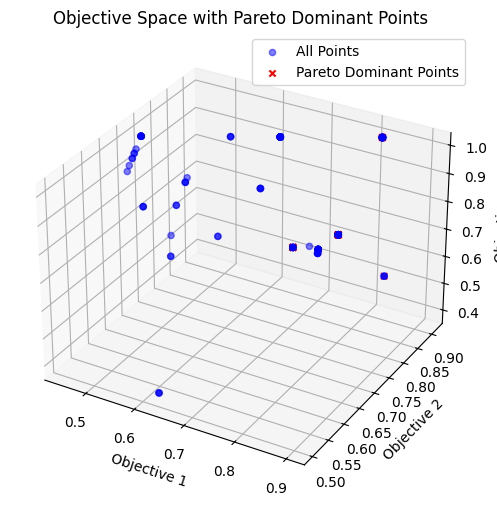

In [171]:
graficar(objetivos * -1)
# PBI

### P2


Cantidad de puntos no dominados: 109


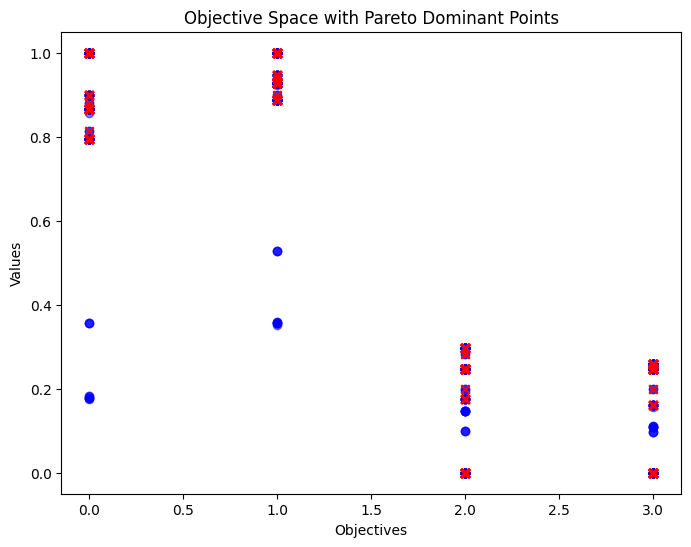

In [ ]:
graficar(objetivos * -1)
# Weighted sum